Skipping row due to error: time data 'time' does not match format '%Y-%m-%d %H:%M:%S.%f'
Mean Squared Error: 0.467672171042977
Interval	Actual MET	Predicted MET
walk_1	3.0	3.853395064583902
walk_2	3.5	3.955039784886763
walk_3	4.0	4.0
walk_4	4.5	4.500000000000001
run_1	8.0	7.999999999999998
run_2	10.0	10.0


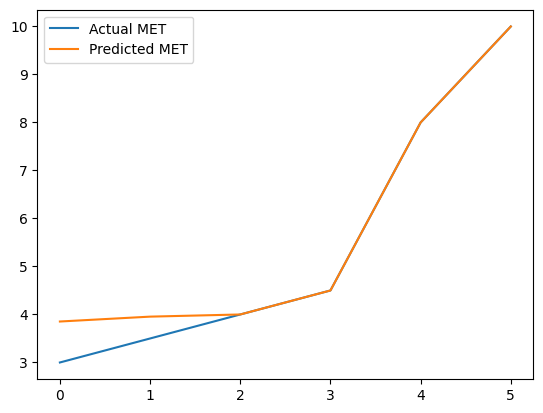

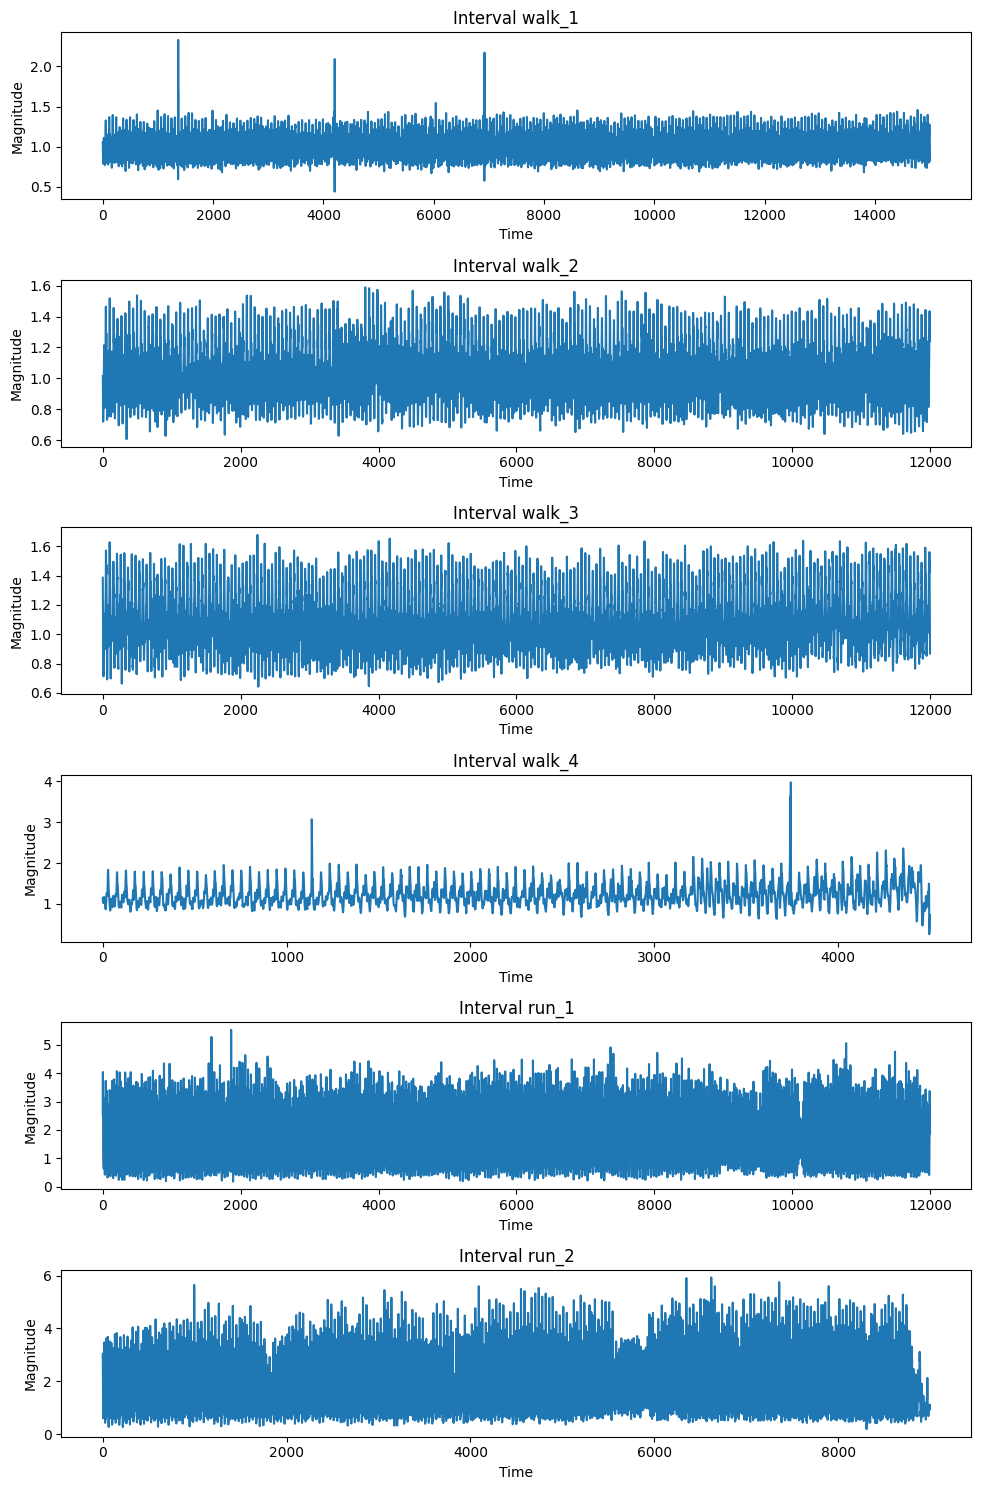

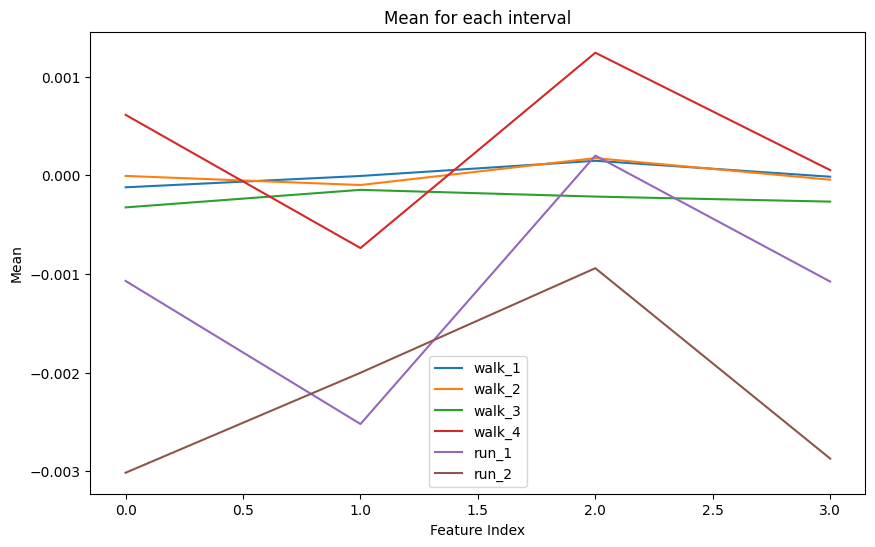

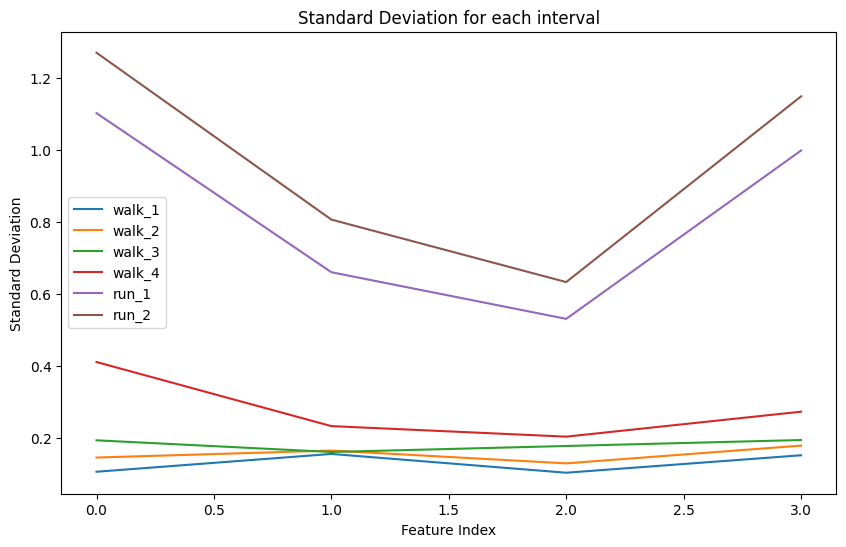

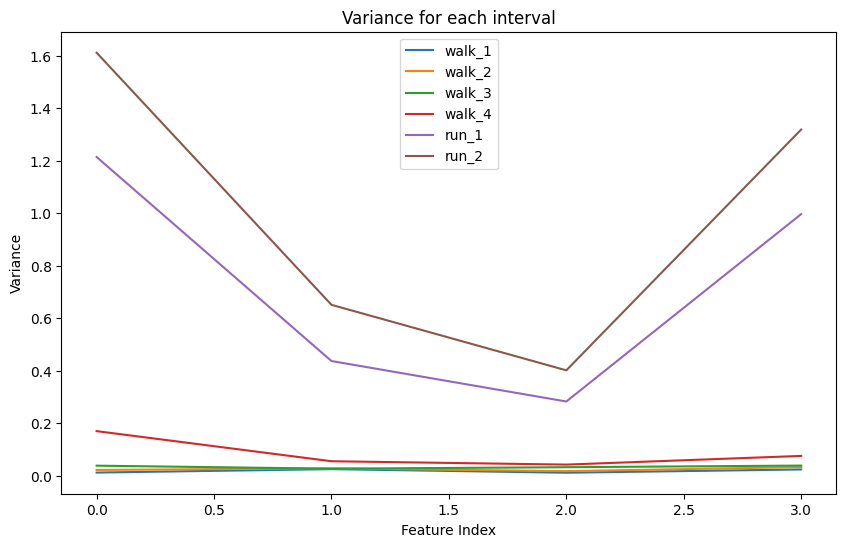

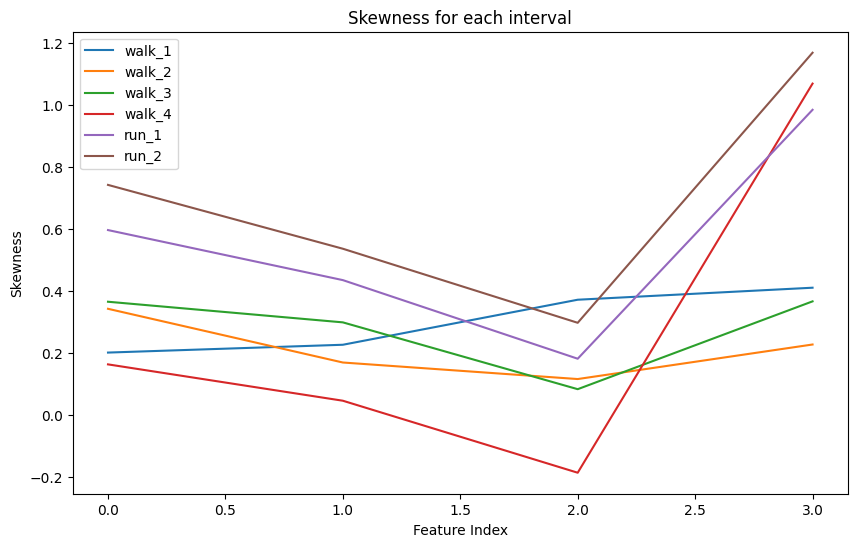

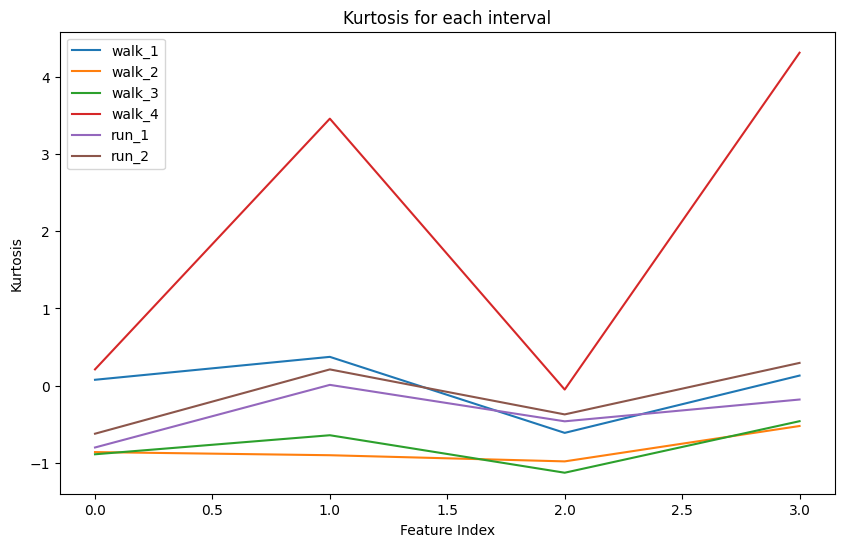

In [25]:
import csv
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import skew, kurtosis
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Define the time intervals and corresponding MET values
intervals = {
    'walk_1': {'times': ('15:36:00', '15:41:00'), 'MET': 3.0},
    'walk_2': {'times': ('15:43:00', '15:47:00'), 'MET': 3.5},
    'walk_3': {'times': ('15:49:00', '15:53:00'), 'MET': 4.0},
    'walk_4': {'times': ('15:54:30', '15:56:00'), 'MET': 4.5},
    'run_1': {'times': ('15:59:00', '16:03:00'), 'MET': 8.0},
        'run_2': {'times': ('16:06:30', '16:09:30'), 'MET': 10.0}
    }


# Convert time strings to datetime objects
for key in intervals:
    start_time_str, end_time_str = intervals[key]['times']
    intervals[key]['times'] = (
        datetime.strptime(start_time_str, '%H:%M:%S'),
        datetime.strptime(end_time_str, '%H:%M:%S')
    )

# Function to extract features from acceleration data
def extract_features(acc_data):
    mean = np.mean(acc_data, axis=0)
    std_dev = np.std(acc_data, axis=0)
    var = np.var(acc_data, axis=0)
    skewness = skew(acc_data, axis=0)
    kurt = kurtosis(acc_data, axis=0)
    return [mean, std_dev, var, skewness, kurt]

# Define high-pass filter parameters
def butter_highpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Read the data from the CSV file and process it
acc_data = []
with open("/Users/sh/Documents/FdS/Master 2 IDS/S1/Santé AP/Data/data_motet.csv", 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        try:
            if len(row) < 4:
                raise ValueError("Row has missing values")
            timestamp = datetime.strptime(row[0], '%Y-%m-%d %H:%M:%S.%f')
            x = float(row[1])
            y = float(row[2])
            z = float(row[3])
            acc_data.append([timestamp, x, y, z])
        except (ValueError, IndexError) as e:
            print(f"Skipping row due to error: {e}")
            continue

# Sampling frequency and cutoff frequency
fs = 50.0    # Sampling frequency in Hz
cutoff = 0.3  # Cutoff frequency in Hz

# Process the data for each interval
stats_list = []
for label, info in intervals.items():
    start_time = info['times'][0].time()
    end_time = info['times'][1].time()
    
    interval_data = [row for row in acc_data if start_time <= row[0].time() <= end_time]
    if not interval_data:
        print(f"No data found for interval: {label}")
        continue
    
    interval_data = np.array(interval_data, dtype=object)
    interval_data = interval_data[:, 1:].astype(float)
    x_accel = interval_data[:, 0]
    y_accel = interval_data[:, 1]
    z_accel = interval_data[:, 2]
    
    # Calculate magnitude
    accel_magnitude = np.sqrt(np.square(x_accel) + np.square(y_accel) + np.square(z_accel))
    
    # Apply high-pass filter for gravity compensation
    x_accel_compensated = highpass_filter(x_accel, cutoff, fs)
    y_accel_compensated = highpass_filter(y_accel, cutoff, fs)
    z_accel_compensated = highpass_filter(z_accel, cutoff, fs)
    accel_magnitude_compensated = highpass_filter(accel_magnitude, cutoff, fs)
    
    # Extract features
    features = extract_features(np.column_stack((x_accel_compensated, y_accel_compensated, z_accel_compensated,accel_magnitude_compensated)))
    
    stats_list.append({
        'Interval': label,
        'Mean': features[0],
        'Standard Deviation': features[1],
        'Variance': features[2],
        'Skewness': features[3],
        'Kurtosis': features[4],
        'MET': info['MET']
    })

# Prepare the dataset for regression
X = []
y = []

for stats in stats_list:
    features = [
        stats['Mean'],
        stats['Standard Deviation'],
        stats['Variance'],
        stats['Skewness'],
        stats['Kurtosis']
    ]
    X.append(np.concatenate(features).ravel())
    y.append(stats['MET'])

# Convert lists to numpy arrays for modeling
X = np.array(X)
y = np.array(y)

# Split the data into training and validation sets (e.g., 80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the validation data
y_pred = model.predict(X_val)

# Evaluate the model's performance
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

# Predict MET values based on extracted features
predicted_MET = model.predict(X)

# Display actual vs predicted MET values
print("Interval\tActual MET\tPredicted MET")
for idx, stats in enumerate(stats_list):
    print(f"{stats['Interval']}\t{stats['MET']}\t{predicted_MET[idx]}")

# Function to plot intervals
def plot_intervals(acc_data, intervals):
    fig, axs = plt.subplots(len(intervals), 1, figsize=(10, 15))
    
    for i, (label, info) in enumerate(intervals.items()):
        start_time = info['times'][0].time()
        end_time = info['times'][1].time()
        
        interval_data = [row for row in acc_data if start_time <= row[0].time() <= end_time]
        if not interval_data:
            print(f"No data found for interval: {label}")
            continue
        
        interval_data = np.array(interval_data, dtype=object)
        interval_data = interval_data[:, 1:].astype(float)
        x_accel = interval_data[:, 0]
        y_accel = interval_data[:, 1]
        z_accel = interval_data[:, 2]
        
        # Calculate magnitude
        accel_magnitude = np.sqrt(np.square(x_accel) + np.square(y_accel) + np.square(z_accel))
        
        axs[i].plot(accel_magnitude)
        axs[i].set_title(f'Interval {label}')
        axs[i].set_xlabel('Time')
        axs[i].set_ylabel('Magnitude')
    
    plt.tight_layout()
    plt.show()

# Plot actual vs predicted MET values
plt.plot(y, label='Actual MET')
plt.plot(predicted_MET, label='Predicted MET')
plt.legend()
plt.show()

# Call the plot_intervals function
plot_intervals(acc_data, intervals)

# Plot the features for each interval
features = ['Mean', 'Standard Deviation', 'Variance', 'Skewness', 'Kurtosis']
for feature in features:
    plt.figure(figsize=(10, 6))
    for stats in stats_list:
        plt.plot(stats[feature], label=stats['Interval'])
    plt.title(f'{feature} for each interval')
    plt.xlabel('Feature Index')
    plt.ylabel(feature)
    plt.legend()




plt.show()